# Analysis of June 15th 2022 Flight

Goal: 
1. Import the data one time
2. Plot in modifiable windows
3. Do basic analysis with static mask
4. Show results in pretty plots

In [1]:
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

In [2]:
df = main.get_data("Alton", "june15_2022.BIN")

Recording    - INFO     - Loading recording file using reader: ArdupilotDFReader and processor: Createv2022Dataflash
ArdupilotDFReader - INFO     - Begin processing /Users/williamkemp/Records/Repositories/CREATeV_power/data/june15_2022.BIN
ArdupilotDFReader - INFO     - GPS time found on channel=GPS, instance=0
ArdupilotDFReader - INFO     - 2022-06-15 06:24:37 at board time = 1970-01-01 00:37:03.325496


In [3]:
# Vehicle parameters
prop = propellers.aeronaut185x12() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

In [4]:
### Mask Initialization ###

mask = np.array([[9000, 9575],
                [9600, 10200],
                [10200,10900],
                [10900,11500],
                [11500,11900],
                [12800,13049],
                [13057,13350],
                [13400,13950],
                [14050,14450]])

desc_mask = np.array([[3449, 3497],
                    [3687, 3744],
                    [3931 , 3991],
                    [4166 , 4231],
                    [4419 , 4487],
                    [4653 , 4737],
                    [4915 , 4988],
                    [5159 , 5236],
                    [5395 , 5476],
                    [5648 , 5741],
                    [5922 , 6007],
                    [6194 , 6279],
                    [6462 , 6550],
                    [6743 , 6841],
                    [7039 , 7149],
                    [7347 , 7458],
                    [7672 , 7770],
                    [7980 , 8078],
                    [8302 , 8423],
                    [8586 , 8690]])

In [5]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_desc = cl_finders.desc2preq(createv, prop, rho, v_tas, n, q, Vd_tas)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
Cd_desc = cl_finders.preq2cd(createv, v_tas, q, P_desc)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

-0.059006257500000825
-0.1271989126147464
[nan  0.  0. ...  0.  0.  0.]


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_73057/2642072233.py:22: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_73057/2642072233.py:22: RuntimeWarning: invalid value encountered in true_divide
  J = v_tas / (n * prop.diameter)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/propellers.py:79: RuntimeWarning: invalid value encountered in subtract
  CT = 0.01649*J**3 - 0.224*J**2 + 0.04329*J + 0.08563
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/propellers.py:84: RuntimeWarning: invalid value encountered in add
  CP = -0.2103*J**3 + 0.1318*J**2 - 0.033076*J + 0.04726
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/motors.py:38: RuntimeWarning: divide by zero encountered in true_divide
  efficiency = (1 - (i0/current)) * (Kv/Kq) * (1 + tau*omega + current*R*Kv*omega**-1)**-1;
/Users/williamkemp/Records/Repositories/CREATeV_An

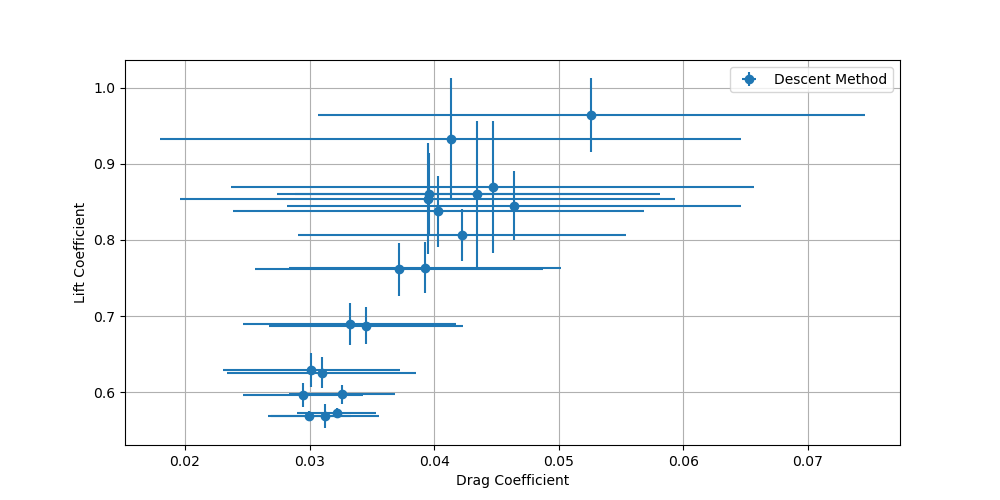

In [6]:
# Descending mask
CDdesc_ave = np.zeros(len(desc_mask))
CLdesc_ave = np.zeros(len(desc_mask))
CDdesc_std = np.zeros(len(desc_mask))
CLdesc_std = np.zeros(len(desc_mask))

EASdesc_ave = np.zeros(len(desc_mask))

for i in range(len(desc_mask)):
    CDdesc_ave[i] = np.mean(Cd_desc[int(desc_mask[i,0]):int(desc_mask[i,1])])
    CLdesc_ave[i] = np.mean(CL[int(desc_mask[i,0]):int(desc_mask[i,1])])
    EASdesc_ave[i] = np.mean(v_eas[int(desc_mask[i,0]):int(desc_mask[i,1])])

    CDdesc_std[i] = np.std(Cd_desc[int(desc_mask[i,0]):int(desc_mask[i,1])])
    CLdesc_std[i] = np.std(CL[int(desc_mask[i,0]):int(desc_mask[i,1])])

polar_desc = cl_finders.cd2polar(createv, CDdesc_ave, CLdesc_ave)
Peq_desc, EAS = cl_finders.polar2preqew(createv, polar_desc, (7,14))

plt.figure(figsize=(10,5))
plt.errorbar(CDdesc_ave, CLdesc_ave, xerr=CDdesc_std, yerr=CLdesc_std, fmt='o', label="Descent Method")
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.legend()
plt.grid(True)
plt.show()

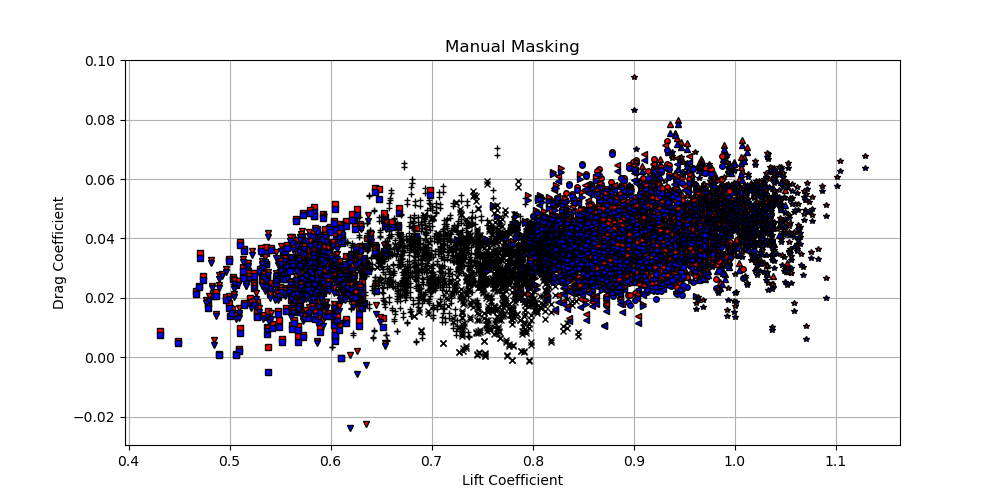

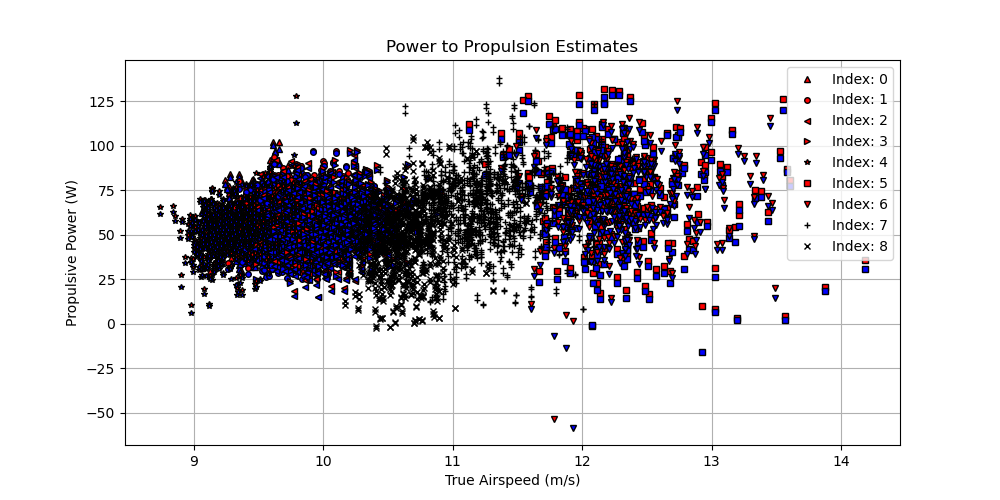

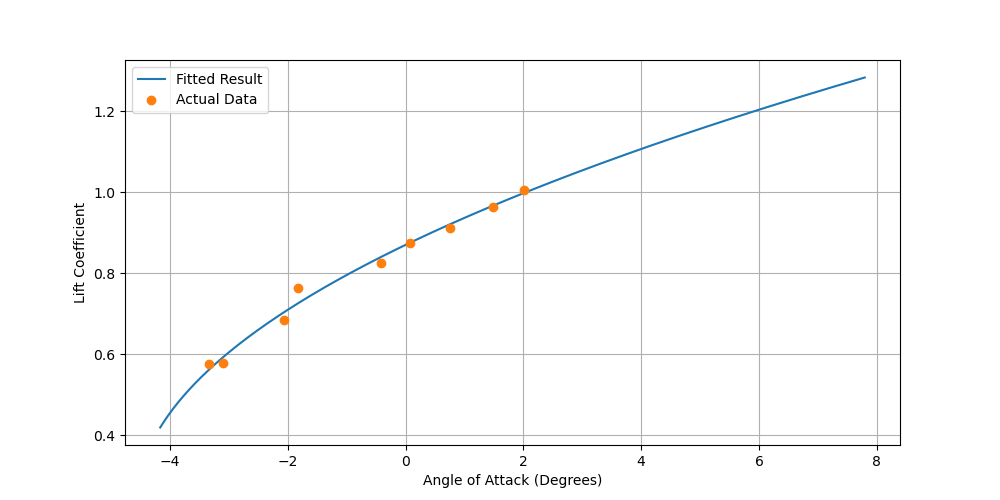

In [11]:

# Plot with static masking
plt.figure(figsize=(10,5))
plt.title("Manual Masking")

markers = ['^', 'o', '<', '>', '*', 's', 'v', '+', 'x', 'D', '.']

for i in range(len(mask)):
    plt.plot(CL[int(mask[i,0]):int(mask[i,1])], Cd_eta[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    plt.plot(CL[int(mask[i,0]):int(mask[i,1])], Cd_ct[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
    
plt.grid(True)
plt.xlabel("Lift Coefficient")
plt.ylabel("Drag Coefficient")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Power to Propulsion Estimates")
for i in range(len(mask)):
    plt.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_eta[int(mask[i,0]):int(mask[i,1])], label="Index: "+str(i), linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    plt.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_ct[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
plt.grid(True)
plt.xlabel("True Airspeed (m/s)")
plt.ylabel("Propulsive Power (W)")
plt.legend()
plt.show()

# Loitering mask
CDct_ave = np.zeros(len(mask))
CDeta_ave = np.zeros(len(mask))

CL_ave = np.zeros(len(mask))
EAS_ave = np.zeros(len(mask))

pitch_ave = np.zeros(len(mask))

CDct_std = np.zeros(len(mask))
CDeta_std = np.zeros(len(mask))
CL_std = np.zeros(len(mask))

for i in range(len(mask)):
    
    CDeta_ave[i] = np.mean(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_ave[i] = np.mean(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_ave[i] = np.mean(CL[int(mask[i,0]):int(mask[i,1])])
    EAS_ave[i] = np.mean(v_eas[int(mask[i,0]):int(mask[i,1])])
    pitch_ave[i] = np.mean(pitch[int(mask[i,0]):int(mask[i,1])])
    
    CDeta_std[i] = np.std(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_std[i] = np.std(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_std[i] = np.std(CL[int(mask[i,0]):int(mask[i,1])])

# Finding drag polar:
polar_eta = cl_finders.cd2polar(createv, CDeta_ave, CL_ave)
polar_ct = cl_finders.cd2polar(createv, CDct_ave, CL_ave)

# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_eta, EAS = cl_finders.polar2preqew(createv, polar_eta, (8,14))
Peq_ct, EAS = cl_finders.polar2preqew(createv, polar_ct, (8,14))

# Finding AOA correlation to Coefficient of Lift:
CL_alpha = cl_finders.angleModel(CL_ave, pitch_ave, "linear")
EAS_model, CL_model, CD_model, AoA_model = cl_finders.basicModel(createv, polar_ct, CL_alpha, (8,14))

export = np.transpose(np.vstack((EAS_model, CD_model, CL_model, AoA_model)))

plt.figure(figsize=(10,5))
plt.plot(AoA_model, CL_model, label='Fitted Result')
plt.plot(np.rad2deg(pitch_ave), CL_ave, linestyle='None', marker='o', label='Actual Data')
plt.legend()
plt.xlabel("Angle of Attack (Degrees)")
plt.ylabel("Lift Coefficient")
plt.grid(True)
plt.show()

tmp =  {'data': export}
scipy.io.savemat('simpleModel.mat', {'data': export})

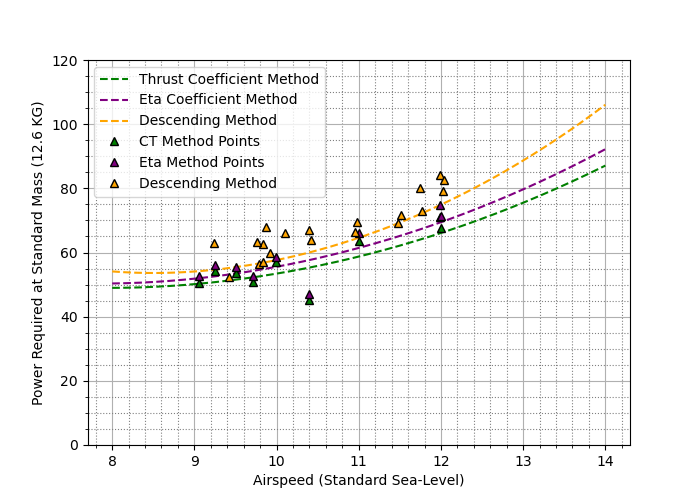

In [8]:
plt.figure(figsize=(7,5))
plt.plot(EAS, Peq_ct, label="Thrust Coefficient Method", color='green', linestyle='--')
plt.plot(EAS, Peq_eta, label="Eta Coefficient Method", color='purple', linestyle='--')
plt.plot(EAS, Peq_desc, label="Descending Method", color='orange', linestyle='--')
plt.plot(EAS_ave, CDct_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, linestyle='', marker='^', color='green', markeredgecolor=[0,0,0], label='CT Method Points')
plt.plot(EAS_ave, CDeta_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, linestyle='', marker='^', color='purple', markeredgecolor=[0,0,0], label='Eta Method Points')
plt.plot(EASdesc_ave, CDdesc_ave * 0.5 * 1.225 * EASdesc_ave**3 * createv.area, linestyle='', color='orange', marker='^', markeredgecolor=[0,0,0], label='Descending Method')
plt.xlabel("Airspeed (Standard Sea-Level)")
plt.ylabel("Power Required at Standard Mass (12.6 KG)")
plt.ylim([0, 120])
plt.legend()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.show()


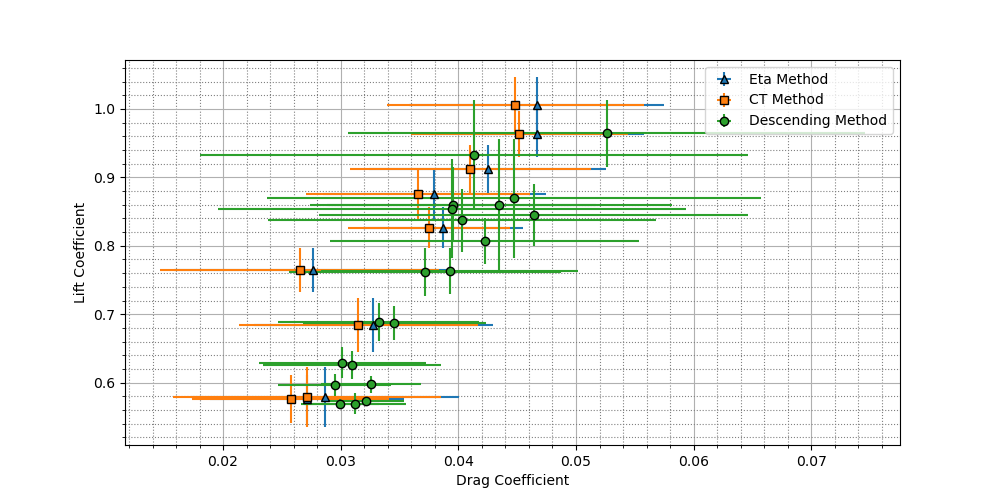

In [9]:
plt.figure(figsize=(10,5))
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_std, yerr=CL_std, fmt='^', label="Eta Method", markeredgecolor=[0,0,0])
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_std, yerr=CL_std, fmt='s', label="CT Method", markeredgecolor=[0,0,0])
plt.errorbar(CDdesc_ave, CLdesc_ave, xerr=CDdesc_std, yerr=CLdesc_std, fmt='o', label = "Descending Method", markeredgecolor=[0,0,0])
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.legend()
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.show()

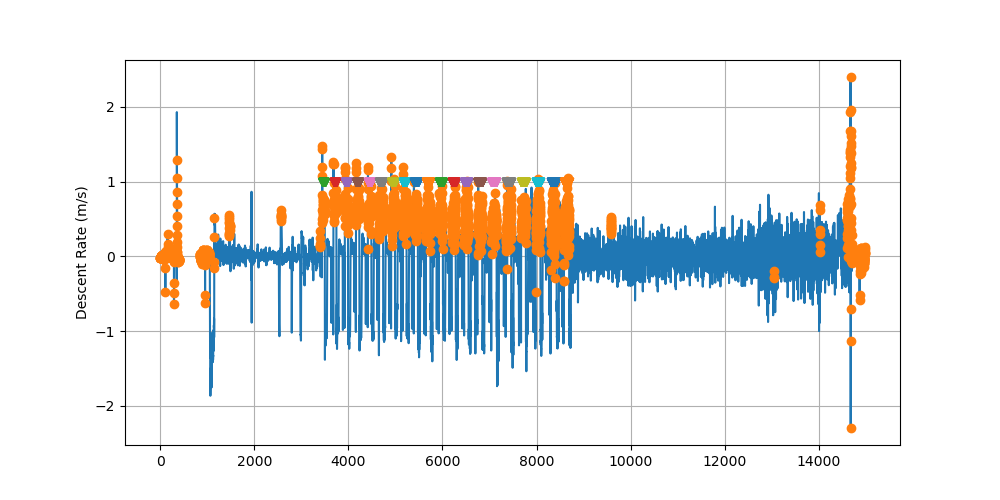

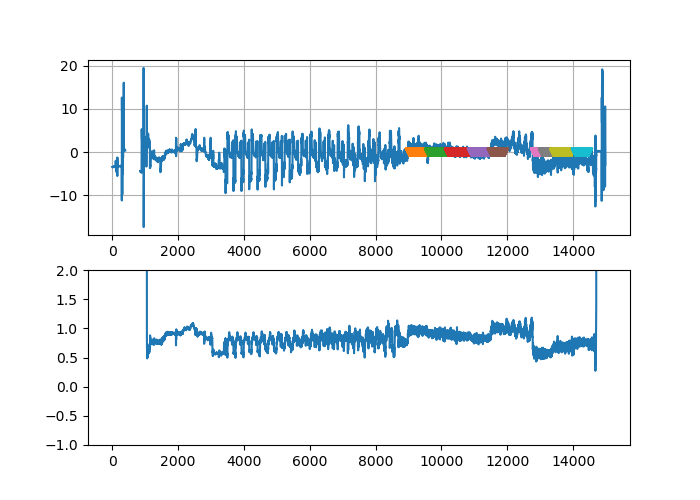

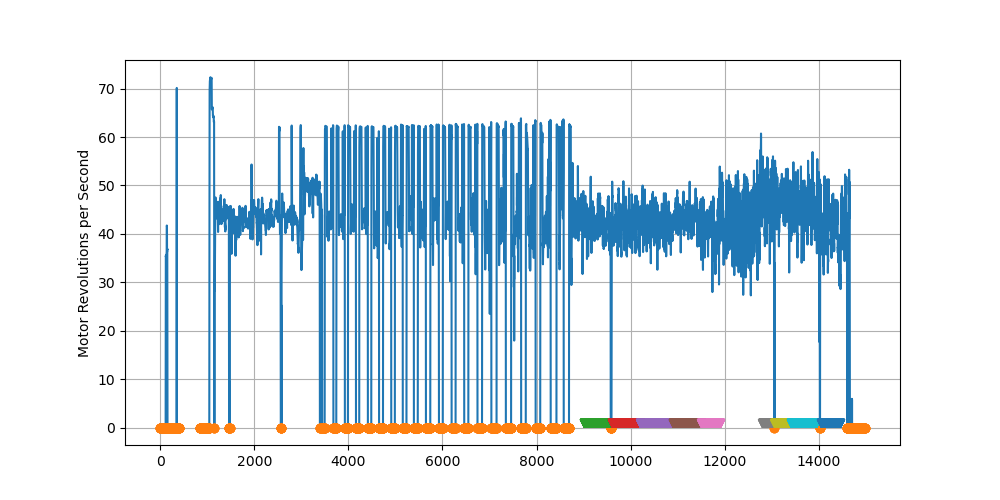

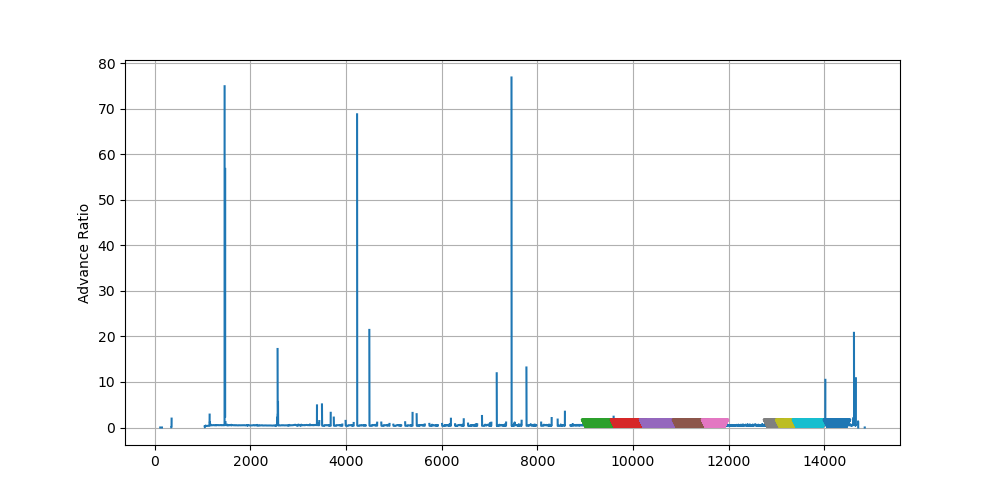

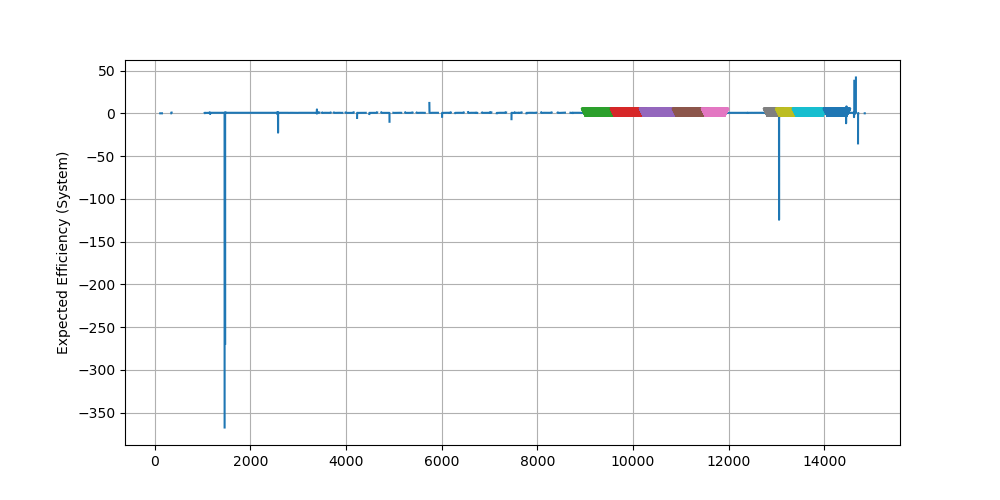

In [10]:
plt.figure(figsize=(10,5))
plt.plot(n)
plt.plot(np.transpose(np.where(n == 0)), n[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Motor Revolutions per Second")

plt.figure(figsize=(10,5))
plt.plot(J)
plt.plot(np.transpose(np.where(n == 0)), J[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Advance Ratio")

plt.figure(figsize=(10,5))
plt.plot(eff)
plt.plot(np.transpose(np.where(n == 0)), eff[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Expected Efficiency (System)")

plt.figure(figsize=(10,5))
plt.plot(Vd_tas)
plt.plot(np.transpose(np.where(n == 0)), Vd_tas[n == 0], linestyle='None', marker='o')
for i in range(len(desc_mask)):
    segment = np.arange(desc_mask[i,0],desc_mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Descent Rate (m/s)")
plt.show()

plt.figure(figsize=(7,5))

ax1 = plt.subplot(2,1,1)
ax1.plot(np.rad2deg(pitch))
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    ax1.plot(segment, np.zeros(len(segment)), marker='v')
ax1.grid(True)
#plt.ylabel("Pitch Angle (degrees)")

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(CL)
ax2.set_ylim([-1,2])
#plt.ylabel("Coefficient of")

plt.show()